In [132]:
%load_ext autoreload
%autoreload 2
import RNA
import numpy as np
import matplotlib.pyplot as plt
import os

from utils import calc_MCC, dict_dot_bracket, list_dot_bracket, forna_display, parse_rdat, parse_drt_file
from penalties import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# Parse SHAPE files into dicts with seqs and scores
shape_data = {}
rdat_files = sorted(['SRP_test/'+f for f in os.listdir('SRP_test') if 'rdat' in f])
#rdat_files = ['SRP_test/'+'SRPECLI_BZCN_0001.rdat.txt']
for r in rdat_files:
    shape_data[r.strip('SRP_test/SRPECLI_').strip('.rdat.txt')] = parse_rdat(r)

md = RNA.md()
md.temperature = 37 #Both transcription and modification was done at 37

In [134]:
# Create reference datasets for the best of each algorithm
compute_data = {}

ref_name = list(shape_data.keys())[0]

name_func_map = {'no_constraint' : no_constraint, 
                 'mfe_const' : constant_penalty, 
                 'mfe_seq_dep' : sequence_dependent_penalty,
                 #'hierarchical' : hierarchical_fold, 
                 'ensemble_const' : constant_ensemble_penalty, 
                 'ensemble_seq_dep' : sequence_dependent_ensemble_penalty
                 }

name_pen_map = {'no_constraint' : 0, 
                 'mfe_const' : 20, 
                 'mfe_seq_dep' : 0.034,
                 #'hierarchical' : 10, 
                 'ensemble_const' : 15, 
                 'ensemble_seq_dep' : 0.034
                 }

for dn in name_func_map.keys():
    compute_data[dn] = {
        'func' : name_func_map[dn],
        'pen' : name_pen_map[dn]
    }
    for l in shape_data[ref_name]:
        compute_data[dn][l] = {
            'seq' : shape_data[ref_name][l]['seq'],
        }

In [135]:
# Calculate folding pathways for each SHAPE dataset
for n, d in shape_data.items():
    print(f'Working on {n}')
    for length in d.keys():
        subseq = d[length]['seq']
        reactivities = d[length]['react']
        d[length]['mfe'] = shape_constraint(subseq, reactivities, md)[0]


Working on BZCN_0001
Working on BZCN_0002
Working on BZCN_0003
Working on BZCN_0004
Working on DMS_0001
Working on DMS_0002
Working on DMS_0003


In [136]:
# Calculate folding pathways for each kinetic algorithm
for n, d in compute_data.items():
    print(f'Working on {n}')
    if 'ensemble' in n:
        last = []
    else:
        last = ''
        
    for length in d.keys():
        if type(length) != int: # 'func' and 'pen' are also in here
            continue
        subseq = d[length]['seq']
        last = d['func'](subseq, d['pen'], last, md)
        if 'ensemble' in n: # subopt returns a list of subopt objects
            d[length]['mfe'] = last[0].structure
        else: # mfe returns a tuple where 0 is mfe and 1 is energy
            d[length]['mfe'] = last[0]
        

Working on no_constraint
Working on mfe_const
Working on mfe_seq_dep
Working on ensemble_const
Working on ensemble_seq_dep


In [137]:
# also try drtransformer
print("Working on drtransformer")
name = 'SRP_test/SRP_drt.log'

compute_data['drtransformer'] = parse_drt_file(name, shape_data[ref_name])

Working on drtransformer


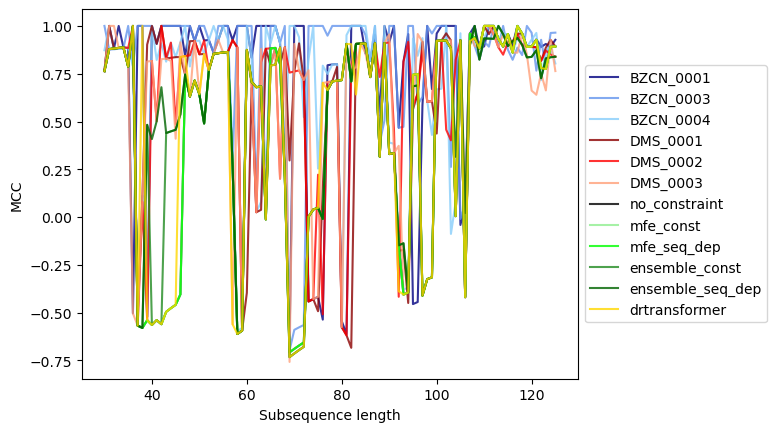

In [138]:
# Plot MCC at each length vs the no_constraints folding
# This at least tells us if if the kinetic method sees the same edges as the SHAPE data predicts
cols = {'BZCN_0001' : 'navy', 
        'BZCN_0002' : 'royalblue', 
        'BZCN_0003' : 'cornflowerblue', 
        'BZCN_0004' : 'lightskyblue', 
        'DMS_0001' : 'darkred', 
        'DMS_0002' : 'red', 
        'DMS_0003' : 'lightsalmon', 
        'mfe_const' : 'lightgreen', 
        'mfe_seq_dep' : 'lime',
        'ensemble_const' : 'forestgreen',
        'ensemble_seq_dep' : 'darkgreen',
        'drtransformer' : 'gold',
        'no_constraint' : 'black'}

reference = 'BZCN_0002' #0002 is the most similar to the other BZCNs

fig, ax = plt.subplots()
for n, d in [it for it in list(shape_data.items()) if it[0] != reference]: 
    x = list(d.keys()) # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data[reference][l]['mfe'])) for l in list(d.keys())]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

for n, d in compute_data.items(): 
    x = [l for l in list(d.keys()) if type(l) == int] # sequence lengths
    y = [calc_MCC(list_dot_bracket(d[l]['mfe']), list_dot_bracket(shape_data[reference][l]['mfe'])) for l in x]
    ax.plot(x, y, c=cols[n], alpha=0.8, label=n)

ax.set_xlabel('Subsequence length')
ax.set_ylabel('MCC')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

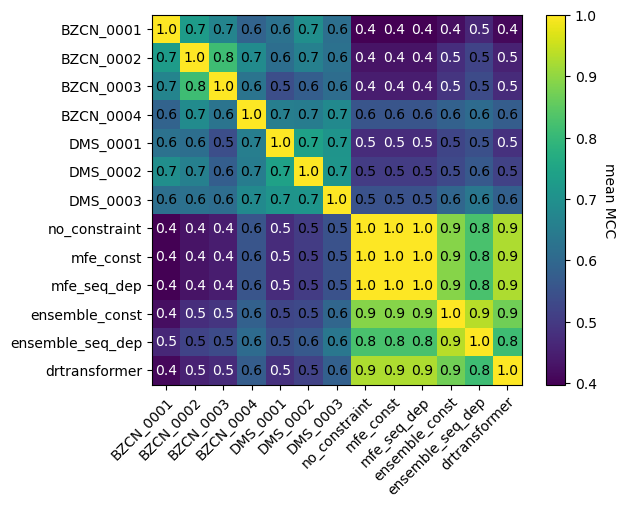

In [139]:
# plot mean MCC between different methods
fig, ax = plt.subplots()

# SHAPE vs SHAPE
corr = np.ones((len(shape_data.keys())+len(compute_data.keys()), len(shape_data.keys())+len(compute_data.keys())))
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(shape_data.items()):
        if i <= j:
            continue
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in list(d1.keys())])
        corr[i, j] = c
        corr[j, i] = c
        
# computed vs computed
for i, (n1, d1) in enumerate(compute_data.items()):
    for j, (n2, d2) in enumerate(compute_data.items()):
        if i <= j:
            continue
        offset = len(shape_data.keys())
        lengths = [l for l in list(d1.keys()) if type(l) == int]
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in lengths])
        corr[i+offset, j+offset] = c
        corr[j+offset, i+offset] = c

# SHAPE vs computed
for i, (n1, d1) in enumerate(shape_data.items()):
    for j, (n2, d2) in enumerate(compute_data.items()):
        offset = len(shape_data.keys())
        lengths = [l for l in list(d1.keys()) if type(l) == int]
        c = np.mean([calc_MCC(list_dot_bracket(d1[l]['mfe']), list_dot_bracket(d2[l]['mfe'])) for l in lengths])
        corr[i, j+offset] = c
        corr[j+offset, i] = c

im = ax.imshow(corr, origin='upper')
ax.set_yticks(np.arange(len(shape_data.keys())+len(compute_data.keys())), list(shape_data.keys())+list(compute_data.keys()))
ax.set_xticks(np.arange(len(shape_data.keys())+len(compute_data.keys())), list(shape_data.keys())+list(compute_data.keys()), rotation=45, ha='right', rotation_mode="anchor")

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(corr.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(corr)):
    for j in range(len(corr)):
        kw.update(color=textcolors[int(corr[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(corr[i,j]), **kw)

plt.show()

In [141]:
# Let's try a single-value penalty sweep.  This isn't going to work, but its useful to see.

penalties = np.arange(5, 105, 5)
pred_at_pen = {}
for p in penalties:
    print("working on penalty =", p)
    pred_at_pen[p] = {}
    last_structure = ''
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']
        
        pred_at_pen[p][length] = constant_penalty(subseq, p, last_structure, md)[0]
        
        last_structure = pred_at_pen[p][length]

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [142]:
penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_pen[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_pen[20].keys())])

In [143]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5	0.543	0.604	0.561
10	0.532	0.589	0.548
15	0.532	0.589	0.548
20	0.541	0.599	0.558
25	0.522	0.574	0.537
30	0.478	0.528	0.492
35	0.465	0.524	0.482
40	0.465	0.524	0.482
45	0.465	0.524	0.482
50	0.457	0.515	0.473
55	0.445	0.504	0.462
60	0.416	0.465	0.430
65	0.512	0.565	0.527
70	0.506	0.562	0.522
75	0.498	0.553	0.514
80	0.468	0.525	0.484
85	0.468	0.525	0.484
90	0.457	0.514	0.473
95	0.457	0.514	0.473
100	0.439	0.496	0.455

Best!
bzcn:	penalty=5 MCC=0.543
dms:	penalty=5 MCC=0.604
all:	penalty=5 MCC=0.561


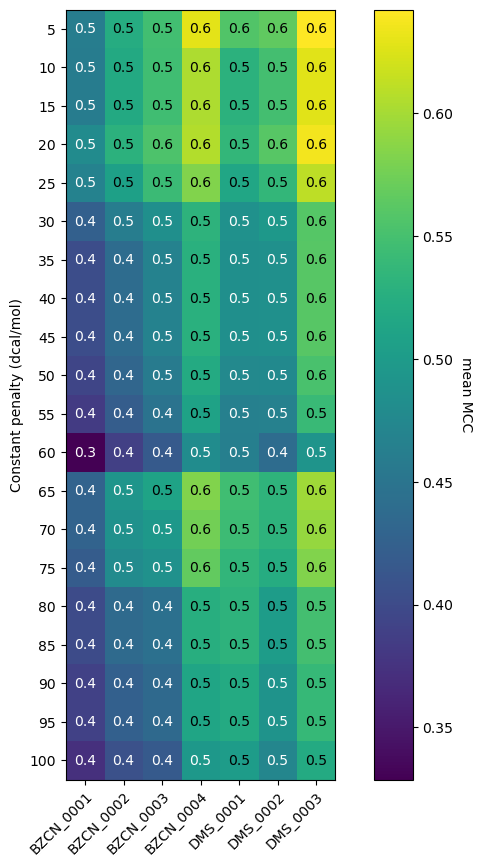

In [144]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(penalty_sweep[i, j]), **kw)

plt.show()

In [ ]:
# Let's try the situation where it's dependent on the base pair broken

percents = np.arange(0.01, 0.262, 0.012)
pred_at_cent = {}
for p in percents:
    print("Working on percentage = {:.3f}".format(p), end='; ')
    pred_at_cent[p] = {}
    p_list = []
    last_structure = ''
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']

        pred_at_cent[p][length] = sequence_dependent_penalty(subseq, p, last_structure, md)[0]
        last_structure = pred_at_cent[p][length]
    
    print("mean penalty = {:.0f}".format(np.mean(p_list)*p))

Working on percentage = 0.010; mean penalty = 4
Working on percentage = 0.022; mean penalty = 9
Working on percentage = 0.034; mean penalty = 14
Working on percentage = 0.046; mean penalty = 19
Working on percentage = 0.058; mean penalty = 24
Working on percentage = 0.070; mean penalty = 29
Working on percentage = 0.082; mean penalty = 34
Working on percentage = 0.094; mean penalty = 39
Working on percentage = 0.106; mean penalty = 44
Working on percentage = 0.118; mean penalty = 49
Working on percentage = 0.130; mean penalty = 54
Working on percentage = 0.142; mean penalty = 59
Working on percentage = 0.154; mean penalty = 64
Working on percentage = 0.166; mean penalty = 69
Working on percentage = 0.178; mean penalty = 74
Working on percentage = 0.190; mean penalty = 79
Working on percentage = 0.202; mean penalty = 84
Working on percentage = 0.214; mean penalty = 89
Working on percentage = 0.226; mean penalty = 94
Working on percentage = 0.238; mean penalty = 99
Working on percentage 

In [ ]:
cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_cent[0.01].keys())])

In [ ]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.557	0.740	0.626
0.022	0.556	0.747	0.627
0.034	0.566	0.760	0.639
0.046	0.566	0.760	0.639
0.058	0.557	0.757	0.632
0.070	0.548	0.732	0.617
0.082	0.542	0.731	0.613
0.094	0.477	0.651	0.542
0.106	0.477	0.651	0.542
0.118	0.468	0.642	0.534
0.130	0.468	0.642	0.534
0.142	0.468	0.642	0.534
0.154	0.429	0.570	0.482
0.166	0.530	0.646	0.574
0.178	0.524	0.643	0.569
0.190	0.516	0.634	0.560
0.202	0.484	0.598	0.527
0.214	0.484	0.598	0.527
0.226	0.484	0.598	0.527
0.238	0.484	0.598	0.527
0.250	0.476	0.589	0.518

Best!
bzcn:	penalty=0.034 MCC=0.566
dms:	penalty=0.034 MCC=0.760
all:	penalty=0.034 MCC=0.639


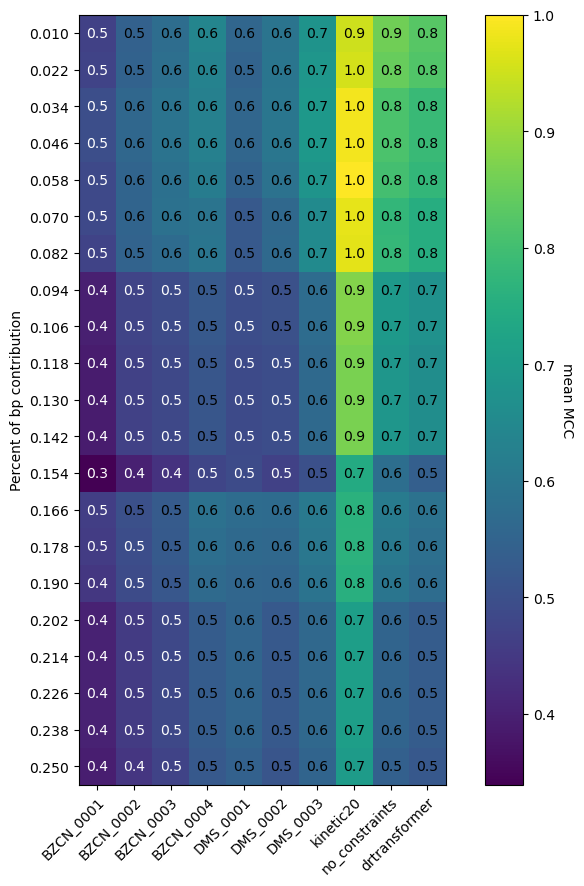

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(cent_sweep[i, j]), **kw)

plt.show()

In [ ]:
#p = .5
#last_structure = ''
#for length in shape_data[ref_name].keys():
#    subseq = shape_data[ref_name][length]['seq']
#    fc = RNA.fold_compound(subseq, md)
#    fc_last = RNA.fold_compound(subseq[:len(last_structure)], md)
#    penalty_dict = get_penalties(last_structure, fc_last)
#    step_info = {
#            'last_dict' : dict_dot_bracket(last_structure),
#            'penalty_dict' : penalty_dict,
#            'penalty_percent' : p
#        }
#    fc.sc_add_f(penalize_barriers_seq)
#    fc.sc_add_data(step_info)
#
#    out = fc.mfe()
#
#    last_structure = out[0]
#    print(out)

In [ ]:
# Let's see how this compares with hierarchical folding
# The problem here is that I have even less of a 'ground truth' in this case
# This didn't work.
#pred_at_span_pen = {}
#full_seq = shape_data[ref_name][list(shape_data[ref_name].keys())[-1]]['seq']
#
#for p in penalties:
#    print("working on penalty =", p)
#    pred_at_span_pen[p] = {}
#    last_structure = ''
#    for length in shape_data[ref_name].keys():
#        pred_at_span_pen[p][length] = hierarchical_fold(full_seq, p, last_structure, length)[0]
#        last_structure = pred_at_span_pen[p][length]


working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [ ]:
#span_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
#for i, p in enumerate(penalties):
#    for j, k in enumerate(shape_data.keys()):
#        span_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_span_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_span_pen[5].keys())])

In [ ]:
#best  = {
#    "bzcn" : {"pen" : -1, "mcc" : -1},
#    "dms" : {"pen" : -1, "mcc" : -1},
#    "all" : {"pen" : -1, "mcc" : -1}
#}
#print(f"Penalty\tBzCN\tDMS\tAll")
#for i, row in enumerate(span_penalty_sweep):
#    bzcn = np.mean(row[0:5])
#    dms = np.mean(row[5:8])
#    all = np.mean(row[0:8])
#    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
#    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
#    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
#    print(f"{penalties[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")
#
#print()
#print("Best!")
#for k, v in best.items():
#    print(f"{k}:\tpenalty={penalties[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5.000	0.337	0.455	0.381
10.000	0.338	0.457	0.383
15.000	0.338	0.457	0.383
20.000	0.238	0.383	0.292
25.000	0.262	0.383	0.308
30.000	0.262	0.383	0.308
35.000	0.262	0.382	0.307
40.000	0.268	0.394	0.315
45.000	0.268	0.394	0.315
50.000	0.268	0.394	0.315
55.000	0.260	0.368	0.300
60.000	0.226	0.333	0.266
65.000	0.081	0.183	0.119
70.000	0.081	0.183	0.119
75.000	0.081	0.183	0.119
80.000	0.081	0.183	0.119
85.000	-0.045	0.057	-0.007
90.000	-0.045	0.057	-0.007
95.000	-0.045	0.057	-0.007
100.000	-0.045	0.057	-0.007

Best!
bzcn:	penalty=10.000 MCC=0.338
dms:	penalty=10.000 MCC=0.457
all:	penalty=10.000 MCC=0.383


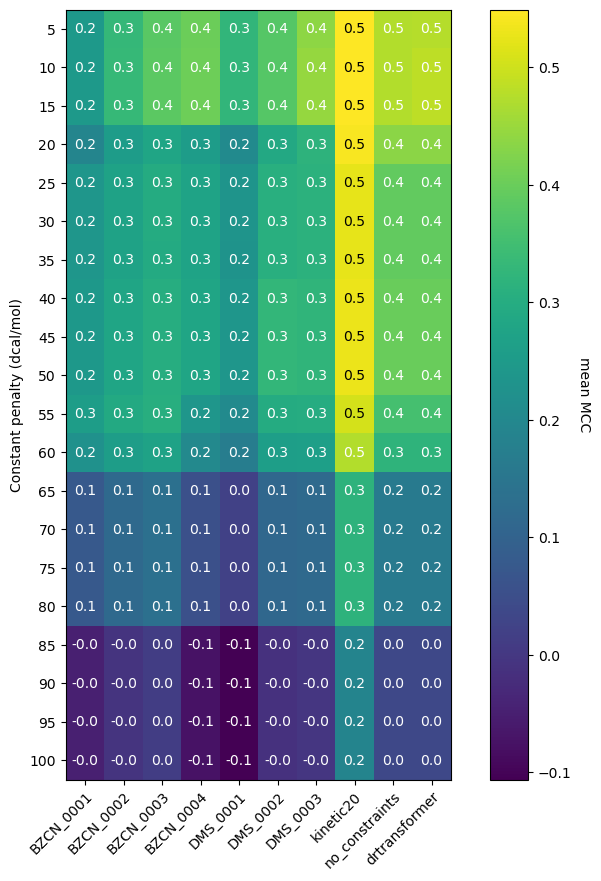

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))
#
#im = ax.imshow(span_penalty_sweep, origin='upper')
#ax.set_yticks(np.arange(len(penalties)), penalties)
#ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
#ax.set_ylabel('Constant penalty (dcal/mol)')
#
#cbar = ax.figure.colorbar(im, ax=ax)
#cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")
#
## annotate heatmap
#threshold = im.norm(span_penalty_sweep.max())/2
#kw = dict(horizontalalignment="center",
#          verticalalignment="center")
#textcolors = ["white", "black"]
#for i in range(len(penalty_sweep)):
#    for j in range(len(shape_data.keys())):
#        kw.update(color=textcolors[int(span_penalty_sweep[i, j] > threshold)])
#        text = im.axes.text(j, i, "{:.1f}".format(span_penalty_sweep[i, j]), **kw)

In [ ]:
# Penalties based on probabilities of folding a given base pair
pred_at_ens_pen = {}

for p in penalties:
    print("working on penalty =", p)
    pred_at_ens_pen[p] = {}
    last_ensemble = []
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']
        
        last_ensemble = constant_ensemble_penalty(subseq, p, last_ensemble, md)
        pred_at_ens_pen[p][length] = last_ensemble[0].structure

working on penalty = 5
working on penalty = 10
working on penalty = 15
working on penalty = 20
working on penalty = 25
working on penalty = 30
working on penalty = 35
working on penalty = 40
working on penalty = 45
working on penalty = 50
working on penalty = 55
working on penalty = 60
working on penalty = 65
working on penalty = 70
working on penalty = 75
working on penalty = 80
working on penalty = 85
working on penalty = 90
working on penalty = 95
working on penalty = 100


In [ ]:
ens_penalty_sweep = np.empty((len(penalties), len(shape_data.keys())))
for i, p in enumerate(penalties):
    for j, k in enumerate(shape_data.keys()):
        ens_penalty_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_pen[p][l])[:l], list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_pen[5].keys())])

In [ ]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_penalty_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{penalties[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={penalties[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
5.000	0.465	0.634	0.528
10.000	0.535	0.713	0.602
15.000	0.541	0.727	0.611
20.000	0.539	0.717	0.606
25.000	0.510	0.686	0.576
30.000	0.509	0.694	0.578
35.000	0.502	0.677	0.568
40.000	0.509	0.685	0.575
45.000	0.508	0.690	0.577
50.000	0.508	0.690	0.576
55.000	0.511	0.688	0.577
60.000	0.502	0.678	0.568
65.000	0.478	0.651	0.543
70.000	0.463	0.633	0.526
75.000	0.452	0.621	0.515
80.000	0.430	0.589	0.490
85.000	0.419	0.573	0.477
90.000	0.403	0.554	0.460
95.000	0.405	0.551	0.460
100.000	0.407	0.548	0.460

Best!
bzcn:	penalty=15.000 MCC=0.541
dms:	penalty=15.000 MCC=0.727
all:	penalty=15.000 MCC=0.611


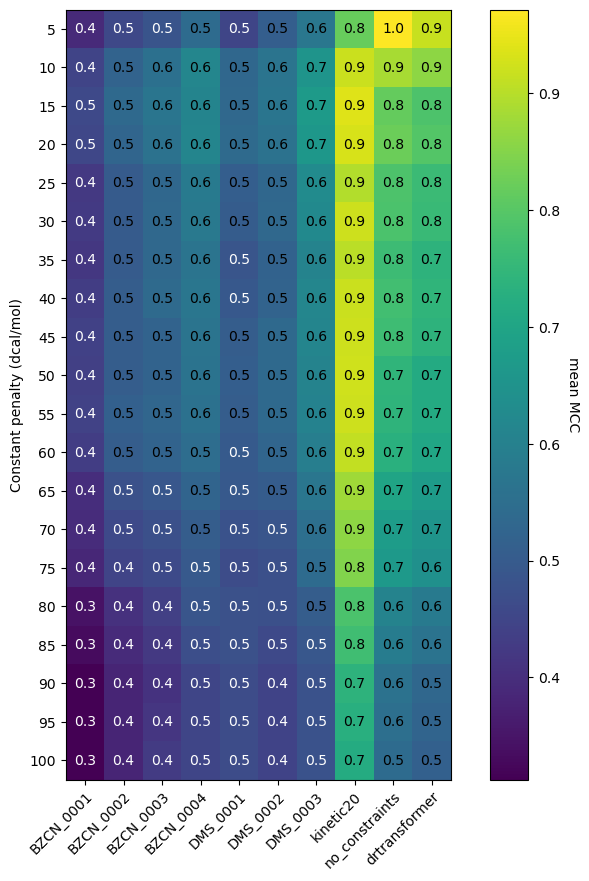

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_penalty_sweep, origin='upper')
ax.set_yticks(np.arange(len(penalties)), penalties)
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Constant penalty (dcal/mol)')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_penalty_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_penalty_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(ens_penalty_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_penalty_sweep[i, j]), **kw)

In [ ]:
mfe_percent = []
e_range = np.arange(50, 1050, 50)
for e in e_range:
    e = int(e)
    fc = RNA.fold_compound(full_seq, md)
    competing = fc.subopt(e)
    energies = np.array([c.energy for c in competing])
    energies *= -1 * 1.624
    mfe_percent.append(np.exp(energies[0]) / np.sum(np.exp(energies)))


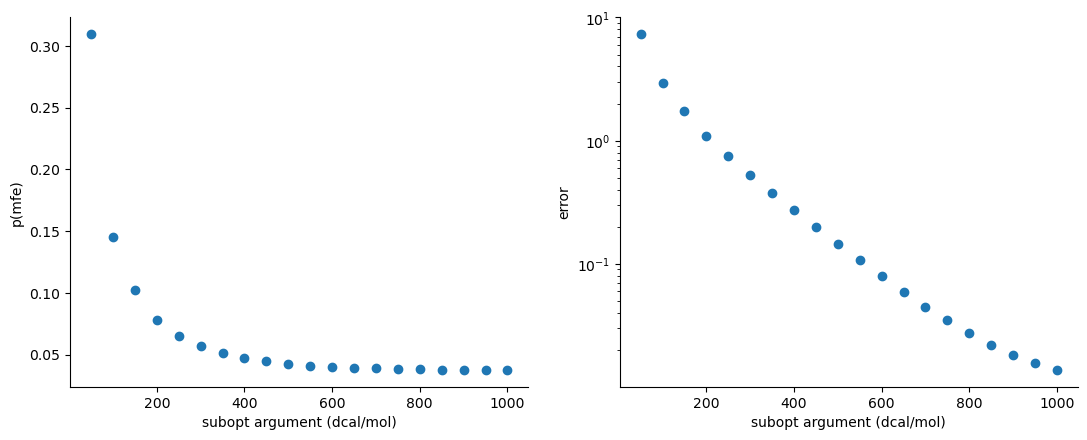

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13,4.8))
ax[0].scatter(e_range, mfe_percent)
ax[0].set_ylabel('p(mfe)')
ax[0].set_xlabel('subopt argument (dcal/mol)')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

real = 0.0370808

error = [(m - real)/real for m in mfe_percent]
ax[1].scatter(e_range, error)
ax[1].set_ylabel('error')
ax[1].set_yscale('log')
ax[1].set_xlabel('subopt argument (dcal/mol)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
plt.show()

In [ ]:
# Penalties based on probabilities of folding a given base pair
pred_at_ens_cent = {}

for p in percents:
    print("Working on percentage = {:.3f}".format(p))
    pred_at_ens_cent[p] = {}
    last_ensemble = []
    for length in shape_data[ref_name].keys():
        subseq = shape_data[ref_name][length]['seq']
        
        last_ensemble = sequence_dependent_ensemble_penalty(subseq, p, last_ensemble, md)
        pred_at_ens_cent[p][length] = last_ensemble[0].structure

Working on percentage = 0.010
Working on percentage = 0.022
Working on percentage = 0.034
Working on percentage = 0.046
Working on percentage = 0.058
Working on percentage = 0.070
Working on percentage = 0.082
Working on percentage = 0.094
Working on percentage = 0.106
Working on percentage = 0.118
Working on percentage = 0.130
Working on percentage = 0.142
Working on percentage = 0.154
Working on percentage = 0.166
Working on percentage = 0.178
Working on percentage = 0.190
Working on percentage = 0.202
Working on percentage = 0.214
Working on percentage = 0.226
Working on percentage = 0.238
Working on percentage = 0.250


In [ ]:
ens_cent_sweep = np.empty((len(percents), len(shape_data.keys())))
for i, p in enumerate(percents):
    for j, k in enumerate(shape_data.keys()):
        ens_cent_sweep[i][j] = np.mean([calc_MCC(list_dot_bracket(pred_at_ens_cent[p][l]), list_dot_bracket(shape_data[k][l]['mfe'])) for l in list(pred_at_ens_cent[0.01].keys())])

In [ ]:
best  = {
    "bzcn" : {"pen" : -1, "mcc" : -1},
    "dms" : {"pen" : -1, "mcc" : -1},
    "all" : {"pen" : -1, "mcc" : -1}
}
print(f"Penalty\tBzCN\tDMS\tAll")
for i, row in enumerate(ens_cent_sweep):
    bzcn = np.mean(row[0:5])
    dms = np.mean(row[5:8])
    all = np.mean(row[0:8])
    best['bzcn'] = {"pen" : i, "mcc" : bzcn} if bzcn > best['bzcn']['mcc'] else best['bzcn']
    best['dms'] = {"pen" : i, "mcc" : dms} if dms > best['dms']['mcc'] else best['dms']
    best['all'] = {"pen" : i, "mcc" : all} if all > best['all']['mcc'] else best['all']
    print(f"{percents[i]:.3f}\t{bzcn:.3f}\t{dms:.3f}\t{all:.3f}")

print()
print("Best!")
for k, v in best.items():
    print(f"{k}:\tpenalty={percents[v['pen']]:.3f} MCC={v['mcc']:.3f}")

Penalty	BzCN	DMS	All
0.010	0.465	0.634	0.529
0.022	0.528	0.704	0.594
0.034	0.552	0.739	0.622
0.046	0.542	0.720	0.609
0.058	0.532	0.710	0.599
0.070	0.517	0.696	0.584
0.082	0.496	0.681	0.565
0.094	0.507	0.697	0.578
0.106	0.534	0.722	0.605
0.118	0.528	0.707	0.595
0.130	0.528	0.707	0.595
0.142	0.510	0.688	0.577
0.154	0.510	0.688	0.577
0.166	0.501	0.677	0.567
0.178	0.496	0.669	0.561
0.190	0.473	0.642	0.536
0.202	0.452	0.622	0.516
0.214	0.439	0.592	0.497
0.226	0.418	0.572	0.476
0.238	0.407	0.560	0.464
0.250	0.404	0.555	0.461

Best!
bzcn:	penalty=0.034 MCC=0.552
dms:	penalty=0.034 MCC=0.739
all:	penalty=0.034 MCC=0.622


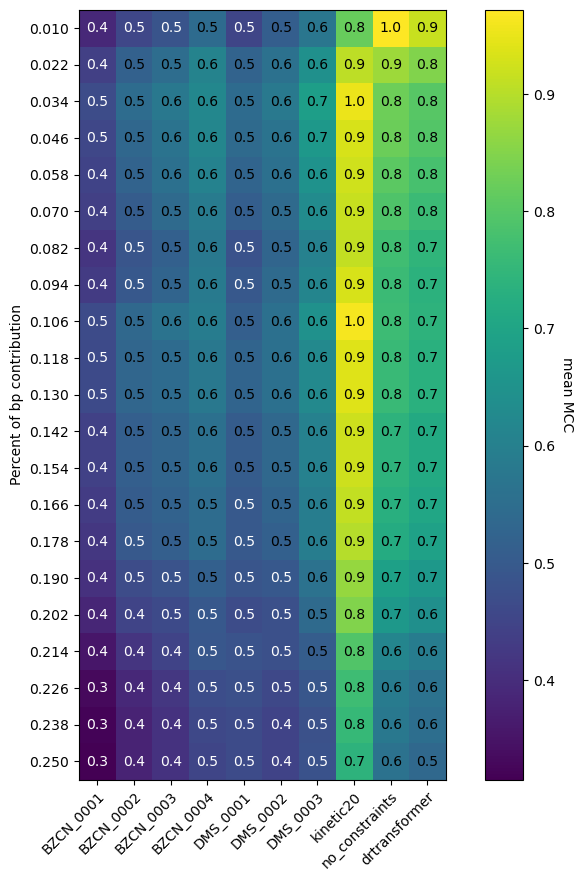

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(ens_cent_sweep, origin='upper')
ax.set_yticks(np.arange(len(percents)), ['{:.3f}'.format(f) for f in percents])
ax.set_xticks(np.arange(len(shape_data.keys())), list(shape_data.keys()), rotation=45, ha='right', rotation_mode="anchor")
ax.set_ylabel('Percent of bp contribution')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('mean MCC', rotation=-90, va="bottom")

# annotate heatmap
threshold = im.norm(ens_cent_sweep.max())/2
kw = dict(horizontalalignment="center",
          verticalalignment="center")
textcolors = ["white", "black"]
for i in range(len(ens_cent_sweep)):
    for j in range(len(shape_data.keys())):
        kw.update(color=textcolors[int(ens_cent_sweep[i, j] > threshold)])
        text = im.axes.text(j, i, "{:.1f}".format(ens_cent_sweep[i, j]), **kw)

In [ ]:
#TODO do the flouride again
#TODO figure out why the fuck the optimal values for penalties have changed.

# Compare against centroid instead of MFE